In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import glob
import os
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LSTM

from sklearn.model_selection import train_test_split

c:\Users\spec3\anaconda3\envs\dgdg\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data Load

In [2]:
labels_dict = {
    "cel": "Cello",
    "cla": "Clarinet ",
    "flu": "Flute",
    "gac": "Acoustuc Guitar",
    "gel": "Electric Guitar",
    "org": "Organ",
    "pia": "Piano",
    "sax": "Saxophone",
    "vio": "Violin",
    "vol": "Voice"
}

In [3]:
total_inst = glob.glob("./sound_track/IRMAS-TrainingData/IRMAS-TrainingData/*/*.wav")
train_path = os.path.join("./sound_track/IRMAS-TrainingData/IRMAS-TrainingData")

In [4]:
total_inst = pd.Series(total_inst)

train_df = pd.DataFrame()
train_df["Class"] = total_inst.map(lambda fn: fn.split("\\")[1])
train_df["FileName"] = total_inst.map(lambda fn: fn.split("\\")[2])

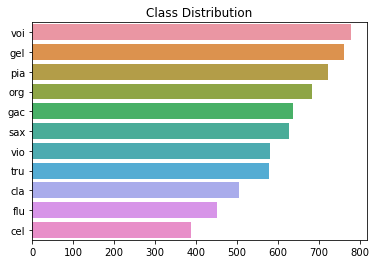

In [5]:
class_count = train_df["Class"].value_counts()
_ = sns.barplot(x=class_count.values, y=class_count.index).set_title("Class Distribution")

### CQT

In [6]:
spt = []

for uid in tqdm(train_df.index):
    df = train_df.iloc[uid]
    path = os.path.join(train_path, df["Class"], df["FileName"])
    # load .wav
    y, sr = librosa.load(path, sr=None)
    ret = librosa.cqt(y, sr)
    ret = np.abs(ret)
    spt.append(ret)

  0%|          | 0/6705 [00:00<?, ?it/s]

C:\Users\spec3\AppData\Local\Temp\ipykernel_32592\1419183808.py:8: FutureWarning: Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ret = librosa.cqt(y, sr)
C:\Users\spec3\AppData\Local\Temp\ipykernel_32592\1419183808.py:8: FutureWarning: Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ret = librosa.cqt(y, sr)


In [7]:
spt =np.array(spt, np.float32)

In [8]:
spt.shape

(6705, 84, 259)

### MFCC

In [14]:
mel = []

for uid in tqdm(train_df.index):
    df = train_df.iloc[uid]
    path = os.path.join(train_path, df["Class"], df["FileName"])
    # load .wav
    y, sr = librosa.load(path, sr=None)
    ret = librosa.feature.mfcc(y, sr, S=spt)
    ret = np.abs(ret)
    mel.append(ret)

  0%|          | 0/6705 [00:00<?, ?it/s]

C:\Users\spec3\AppData\Local\Temp\ipykernel_32592\3875558029.py:8: FutureWarning: Pass y=[-0.00079346 -0.00050354 -0.00019836 ... -0.00367737 -0.00369263
 -0.00367737], sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ret = librosa.feature.mfcc(y, sr, S=spt)
C:\Users\spec3\AppData\Local\Temp\ipykernel_32592\3875558029.py:8: FutureWarning: Pass y=[ 0.00115967  0.0009613   0.00080872 ... -0.00434875 -0.00245667
 -0.00106812], sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ret = librosa.feature.mfcc(y, sr, S=spt)
C:\Users\spec3\AppData\Local\Temp\ipykernel_32592\3875558029.py:8: FutureWarning: Pass y=[-0.00839233 -0.00790405 -0.00756836 ...  0.02723694  0.02484131
  0.02194214], sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ret = librosa.feature.mfcc(y, sr, S=spt)
C:\Users\spec3\AppData\Local\Temp\ipykernel_32

MemoryError: Unable to allocate 132. MiB for an array with shape (6705, 20, 259) and data type float32

In [15]:
mel = np.array(mel, np.float32)
mel.shape

MemoryError: Unable to allocate 45.0 GiB for an array with shape (348, 6705, 20, 259) and data type float32

### Data Split

In [19]:
x = np.expand_dims(spt, -1)
y = pd.get_dummies(train_df["Class"])

In [37]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y)

### Modeling

In [41]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(84, 259, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), (2, 2), padding="same"))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2), (2, 2), padding="valid"))
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), (2, 2), padding="valid"))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2), (2, 2), padding="valid"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(11, activation="softmax"))

In [42]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ["accuracy"]
)

In [43]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=30, monitor="val_loss", restore_best_weights=True)

### Train

In [44]:
with tf.device("/device:GPU:0"):
    hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1000, callbacks=[early_stop])

Epoch 1/1000
168/168 [==============================] - 193s 1s/step - loss: 2.5724 - accuracy: 0.2211 - val_loss: 7.1010 - val_accuracy: 0.1022
Epoch 2/1000
168/168 [==============================] - 192s 1s/step - loss: 1.9436 - accuracy: 0.3304 - val_loss: 5.4974 - val_accuracy: 0.1745
Epoch 3/1000
168/168 [==============================] - 192s 1s/step - loss: 1.7765 - accuracy: 0.4001 - val_loss: 4.9381 - val_accuracy: 0.1559
Epoch 4/1000
168/168 [==============================] - 195s 1s/step - loss: 1.6537 - accuracy: 0.4377 - val_loss: 2.0156 - val_accuracy: 0.3408
Epoch 5/1000
168/168 [==============================] - 203s 1s/step - loss: 1.5006 - accuracy: 0.4966 - val_loss: 2.0804 - val_accuracy: 0.3878
Epoch 6/1000
168/168 [==============================] - 199s 1s/step - loss: 1.3445 - accuracy: 0.5481 - val_loss: 1.7262 - val_accuracy: 0.4385
Epoch 7/1000
168/168 [==============================] - 196s 1s/step - loss: 1.1656 - accuracy: 0.6044 - val_loss: 1.7838 - val_ac

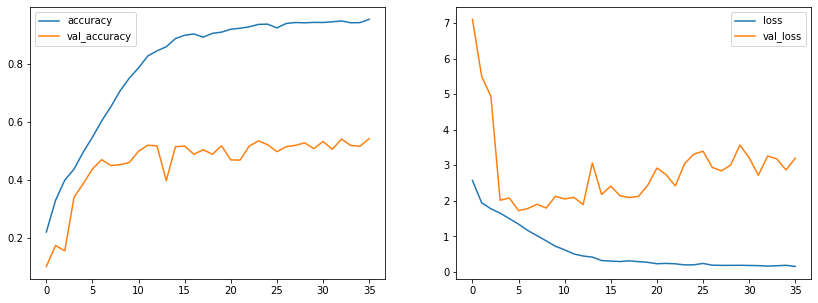

In [45]:
hist_df = pd.DataFrame(hist.history)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
hist_df[["accuracy", "val_accuracy"]].plot(ax=ax[0])
hist_df[["loss", "val_loss"]].plot(ax=ax[1])
plt.show()

In [46]:
test_loss, test_acc = model.evaluate(x, y)

210/210 [==============================] - 44s 211ms/step - loss: 1.3050 - accuracy: 0.5746


In [47]:
model.save("cnn_custom.h5")

### LSTM

In [72]:
model = Sequential()
model.add(LSTM(64, input_shape=(84, 259), return_sequences=True))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(11, activation="softmax"))

In [73]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ["accuracy"]
)

In [74]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=30, monitor="val_loss", restore_best_weights=True)

In [75]:
with tf.device("/device:GPU:0"):
    hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1000, callbacks=[early_stop])

Epoch 1/1000
168/168 [==============================] - 18s 86ms/step - loss: 2.2715 - accuracy: 0.1792 - val_loss: 2.2021 - val_accuracy: 0.2133
Epoch 2/1000
168/168 [==============================] - 13s 77ms/step - loss: 2.1644 - accuracy: 0.2336 - val_loss: 2.1093 - val_accuracy: 0.2670
Epoch 3/1000
168/168 [==============================] - 13s 77ms/step - loss: 2.0610 - accuracy: 0.2806 - val_loss: 2.0131 - val_accuracy: 0.2826
Epoch 4/1000
168/168 [==============================] - 13s 77ms/step - loss: 1.9583 - accuracy: 0.3337 - val_loss: 1.9189 - val_accuracy: 0.3356
Epoch 5/1000
168/168 [==============================] - 13s 77ms/step - loss: 1.8792 - accuracy: 0.3630 - val_loss: 1.8871 - val_accuracy: 0.3386
Epoch 6/1000
168/168 [==============================] - 13s 76ms/step - loss: 1.8168 - accuracy: 0.3831 - val_loss: 1.8235 - val_accuracy: 0.3743
Epoch 7/1000
168/168 [==============================] - 13s 76ms/step - loss: 1.7644 - accuracy: 0.4044 - val_loss: 1.7950 -